In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


### Playing around with using different columns that are complete

In [3]:
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")

In [4]:
# get the cols that in both
tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = set(tr_cols).intersection(te_cols)

In [5]:
train_index = train.index.tolist()
test_index = test.index.tolist()

cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
        'sub_area','kremlin_km','price_doc','timestamp']

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)



locales = pd.read_csv('../data/okurg_chase.csv')
indices = pd.read_csv('../data/district_indices.csv')
macro = pd.read_csv('../data/macro_chase.csv', parse_dates=[0])


macro['quarter'] = pd.PeriodIndex(macro['Unnamed: 0'], freq='Q').strftime('Q%q-%y')
df['month'] = df.timestamp.dt.month.astype(object)
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

df = pd.merge(df,locales[['sub_area','okurg_district']],
              how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

df = pd.merge(df,macro[['quarter','nominal_index']],
              how="left", on="quarter").reset_index(drop=True).set_index(df.index)



# indices['month_year'] = pd.PeriodIndex(indices['date'], freq='M').strftime('%m/%y')
# df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')
# indices.columns = ['id', 'okurg_district', 'month_year', 'price', 'date', 'nominal_index']

In [6]:
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

In [7]:
df['kitch_to_life'] = df.kitch_sq / df.life_sq
df['life_to_full'] = df.life_sq / df.full_sq
# df['bld_type'] = 'med_rise'
# df.loc[df.max_floor <= 5,'bld_type'] = 'low_rise'
# df.loc[df.max_floor >= 17,'bld_type'] = 'high_rise'
df['walk_up_penalty'] = 0
df.loc[(df.floor>4) & (df.max_floor < 6),'walk_up_penalty'] = 1 

In [8]:
df['price_doc'] = df.price_doc / df.nominal_index
df['price_full'] = df.price_doc / df.full_sq
df['log_price'] = np.log(df.price_doc)
# df['price_doc'] = df.price_doc / 1000


### Multiple Linear Regression

In [9]:
print df.shape
recent_df = df[(df.timestamp>'2014-06-02')].copy()
print recent_df.shape
train_index = recent_df[~recent_df.price_doc.isnull()].index.tolist()

(36758, 19)
(18538, 19)


In [14]:
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score

ols = linear_model.LinearRegression()

# cols to drop
# drop_cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']
cols = ['full_sq','floor','sub_area','kremlin_km','month','product_type']
lm_data = recent_df[cols]

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

x_train = df_all.loc[train_index,:]

y_train = recent_df.loc[train_index,'log_price']

x_test = df_all.loc[test_index,:]

ols.fit(x_train,y_train)
print('R^2: %.2f' % ols.score(x_train, y_train))
# df.log_price

R^2: 0.62


In [17]:
df.loc[test_index,'price_doc'] = np.exp(ols.predict(x_test)) * df.loc[test_index,'nominal_index']
df['price_full'] = df.price_doc / df.full_sq
df.loc[df.price_full > 500000,'price_doc'] = df.loc[df.price_full > 500000,'full_sq'] * 500000
df['price_full'] = df.price_doc / df.full_sq

In [18]:
cols = ['price_doc','full_sq','price_full']
sub = df.loc[test_index,cols]

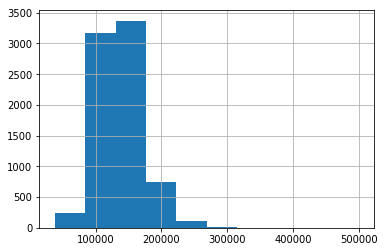

In [21]:
# 0.34331
sub['price_doc'].to_frame().to_csv('../submissions/simple_linear_lfy.csv')

## Looking at stats

Timestamp('2011-08-20 00:00:00')

In [84]:
cols = ['price_full','product_type','full_sq','floor','kremlin_km','sub_area','month']
lm_data = df.loc[train_index,cols].copy()

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

In [85]:
all_columns = "+".join(df_all.columns[1:-1])

In [86]:
model = sm.ols(formula ='price_full ~ ' + all_columns, data = df_all)
fitted = model.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:             price_full   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     69.30
Date:                Sun, 28 May 2017   Prob (F-statistic):               0.00
Time:                        13:25:38   Log-Likelihood:            -1.2784e+05
No. Observations:               10876   AIC:                         2.560e+05
Df Residuals:                   10718   BIC:                         2.571e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

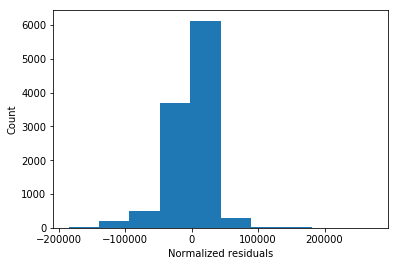

In [87]:
plt.hist(fitted.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [13]:
influence = fitted.get_influence()
#c is the distance and p is p-value
x = pd.DataFrame({'c' :influence.cooks_distance[0], 'p': influence.cooks_distance[1]})
x.sort_values('c')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,c,p
9349,3.474020e-14,1.0
28664,8.983351e-14,1.0
25428,2.247076e-13,1.0
28261,2.778466e-13,1.0
3800,3.988187e-13,1.0
20326,8.023842e-13,1.0
7330,1.619461e-12,1.0
3741,1.730600e-12,1.0
22505,1.953423e-12,1.0
3211,2.099383e-12,1.0


In [ ]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(fitted)
influence_plot(fitted)

In [20]:
cols = ['price_doc','full_sq','sub_area','kremlin_km','price_full']
df.loc[27096,cols]

price_doc               8439.36
full_sq                      55
sub_area      Nagatinskij_Zaton
kremlin_km              8.05738
price_full              153.443
Name: 27096, dtype: object

456.50076120743444

In [119]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.55611992  0.57563789  0.64236933  0.60385353  0.59513042  0.59961819
  0.57438759  0.53179857  0.6425252   0.65684506]


In [120]:
ols.predict(x_test)

array([ 15.243526  ,  15.81082405,  15.33321917, ...,  15.11978371,
        15.37032004,  15.75736919])

In [121]:
cv_scores = cross_val_score(ols, x_train, y_train, cv=10)
print cv_scores

[ 0.55611992  0.57563789  0.64236933  0.60385353  0.59513042  0.59961819
  0.57438759  0.53179857  0.6425252   0.65684506]


In [122]:
test1 = pd.DataFrame({'price_doc': ols.predict(x_test)},index=test_index)

In [123]:
test['price_doc'] = ols.predict(x_test)

In [124]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
lm_predictions = grid.fit(x_train, y_train)

In [125]:
# print lm_predictions.predict(x_train)
print lm_predictions.best_score_

0.597609856336


In [ ]:
from sklearn import preprocessing 

In [ ]:
np.exp(log_y_test)

In [58]:
cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']

pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [59]:
sub = grid.predict(x_test)

In [60]:
sub = pd.DataFrame({'id': test_index, 'price_doc':sub})

In [61]:
sub.loc[:,'nominal_index'] = df.loc[test_index,'nominal_index'].values

In [66]:
'%f' % 1.128899e+08

'112889900.000000'

In [62]:
sub.price_doc = sub.price_doc * sub.nominal_index

In [63]:
sub.loc[:,'price_doc'].to_frame().to_csv('../Chase/submissions/052617_linear_ridge_regression.csv')

In [64]:
sub.sort_values('price_doc')

,id,price_doc,nominal_index
6938,37412,16.722780,1.162486
7654,38128,16.795930,1.162486
5143,35617,16.865221,1.173957
6092,36566,16.874353,1.173957
5422,35896,16.875906,1.173957
4552,35026,16.875906,1.173957
5166,35640,16.875906,1.173957
4112,34586,16.877455,1.173957
5638,36112,16.879989,1.173957
4617,35091,16.887796,1.173957


In [237]:
# df.loc[test_index,'nominal_index']

In [247]:
sub.head()

,id,price_doc,nominal_index
0,30474,4.176246e+06,1.214295
1,30475,9.594552e+06,1.214295
2,30476,5.235794e+06,1.214295
3,30477,9.846788e+06,1.214295
4,30478,2.628036e+06,1.214295
